## 공매도 거래량 상위 50 종목의 위험도 분류

In [1]:
import pandas as pd
import numpy as np
from pykrx import stock
import warnings
import matplotlib.pyplot as plt
warnings = warnings.filterwarnings('ignore')

#### 코스피 공매도 거래량 상위 50종목의 일일 위험도 산출 함수

In [2]:

def danger(day):

    try: 
        #데이터 불러오기#
        trade = stock.get_market_ohlcv(day)             # 해당 날짜의 KOSPI 종목 주가데이터 
        rank = stock.get_shorting_volume_top50(day)     # 공매도 거래량 상위 50종목
        name = stock.get_market_price_change(day,day)   # 종목명 컬럼 사용을 위한 데이터


        #데이터 전처리 과정# 
        name.drop(['시가','종가','거래량','거래대금','등락률'], axis=1,inplace=True)    # 종목명 추출

        many = pd.read_csv('./5years2.csv')     # 최근 5년동안 공매도 과열종목으로 지정된 기업 데이터
        many.drop(['Unnamed: 0'],axis=1,inplace=True)

        rank_trade = pd.merge(rank,trade,on="티커", how='inner')    # rank와 trade 데이터 프레임 병합
        rank_name = pd.merge(rank_trade,name,on='티커',how='inner')     # rank_trade 데이터에 종목명 추가
        rank_name.drop(['총거래대금','고가','저가','거래량','거래대금','변동폭','주가수익률'],axis=1, inplace=True)  # 컬럼 정리
        rank_name =rank_name[['종목명','시가','종가','등락률','공매도거래대금','직전40일거래대금평균', 
                                '공매도거래대금증가율','공매도비중','직전40일공매도평균비중','공매도비중증가율','순위']]    # 컬럼 순서 변경

        rank_name_many = pd.merge(rank_name,many,on='종목명',how='left')       # 공매도 과열종목 지정되었었던 종목 데이터 추가
        rank_name_many.set_index(['종목명'],inplace=True)   # 인덱스 종목코드(티커) -> 종목명으로 변경
        rank_name_many['과열횟수'] = rank_name_many['과열횟수'].fillna(0)       ## 과열횟수의 결측치를 0으로 대체
        

        #위험도 계산을 위한 for문#
        rank_name_many['위험도수치'] = 0        ## 위험도수치를 계산할 컬럼 생성
 
        for i in range(len(rank_name_many)) :       ## 공매도거래대금증가율로 위험도 측정
                if rank_name_many['공매도거래대금증가율'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['공매도거래대금증가율'][i] >= 2.5 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['공매도거래대금증가율'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['공매도거래대금증가율'][i] >= 1.5 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['공매도거래대금증가율'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :       ## 공매도비중증가율로 위험도 측정
                if rank_name_many['공매도비중증가율'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['공매도비중증가율'][i] >= 2.5 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['공매도비중증가율'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['공매도비중증가율'][i] >= 1.5 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['공매도비중증가율'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :      ## 주가하락률로 위험도 측정
                if rank_name_many['등락률'][i] <= -10.0 :   
                    rank_name_many['위험도수치'][i] += 5   
                elif rank_name_many['등락률'][i] <= -8.0 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['등락률'][i] <= -6.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['등락률'][i] <= -4.0 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['등락률'][i] <= -2.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :           # 5년 과열종목 지정 횟수로 위험도 측정 
                if rank_name_many['과열횟수'][i] >= 5.0 :     
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['과열횟수'][i] >= 4.0 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['과열횟수'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['과열횟수'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['과열횟수'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1


        #위험도 수치를 다시 5개의 level로 분류#
        rank_name_many['위험도'] = ''  
        for i in range(len(rank_name_many)) : 
            if rank_name_many['위험도수치'][i]>= 16.0 :     
                rank_name_many['위험도'][i] ='Level5'
            elif rank_name_many['위험도수치'][i] >= 12.0 :
                rank_name_many['위험도'][i] = 'Level4'
            elif rank_name_many['위험도수치'][i] >= 8.0 : 
                rank_name_many['위험도'][i] = 'Level3'
            elif rank_name_many['위험도수치'][i] >= 4.0 : 
                rank_name_many['위험도'][i] = 'Level2'
            elif rank_name_many['위험도수치'][i] >= 0.0 : 
                rank_name_many['위험도'][i] = 'Level1'
            else:
                rank_name_many['위험도'][i] =np.NaN  
            
        return rank_name_many # 개별 종목의 위험도수치와 위험도가 포함된 데이터프레임 추출
    except:
        return '데이터가 없습니다.'

#### 지정 날짜에 찾는 종목이 공매도거래량상위50종목에 들어가는지 확인하는 함수 #

In [3]:
def choose(data, name):
    if name not in data.index:
        return '오늘은 이 종목이 존재하지 않습니다.'
    elif name in data.index:
        return data.loc[[name]]

#### 2022년 05월 11일의 위험도 산출 예시 

형식 : danger('원하는날짜')

In [4]:
df = danger('20220511')
df

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
후성,18900,19050,0.26,5938424650,1900271320,3.12,32.70,6.96,4.70,1,0.0,10,Level3
넷마블,87500,88600,0.23,3069556100,3451718560,0.89,31.56,21.89,1.44,2,4.0,5,Level2
LG생활건강,792000,811000,0.50,15886731000,7024931625,2.26,30.23,12.22,2.47,3,2.0,8,Level3
호텔신라,75800,76100,0.26,7171328600,3998239543,1.79,29.25,16.10,1.82,4,3.0,7,Level2
코웨이,69500,71300,2.30,3349256000,940806713,3.56,28.78,9.58,3.00,5,0.0,10,Level3
태광산업,997000,987000,-1.00,98622000,29979225,3.29,27.09,6.39,4.24,6,0.0,10,Level3
LG디스플레이,17100,16850,-1.75,7404768500,10275561604,0.72,27.06,20.13,1.34,7,2.0,3,Level1
CJ,83800,84500,0.48,676530300,327820335,2.06,26.34,9.22,2.86,8,0.0,7,Level2
GS리테일,25550,25900,0.00,1937630400,921026531,2.10,25.62,9.89,2.59,9,2.0,9,Level3


2022년 5월 11일 공매도 거래량 상위 50종목의 위험도별 개수 시각화 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


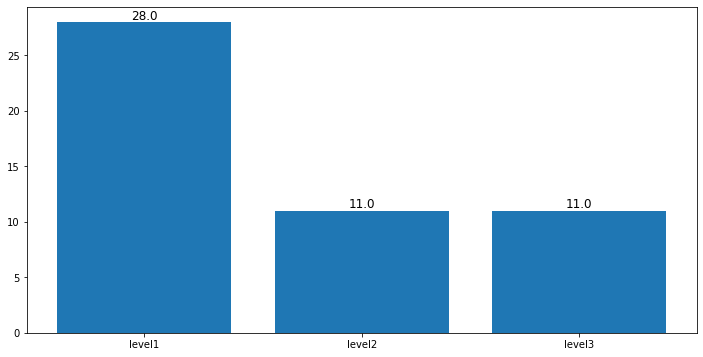

In [5]:
x = ['level1', 'level2', 'level3']
y = pd.DataFrame(df['위험도'].value_counts())
plt.figure(figsize=(12,6))
bar = plt.bar(x,y['위험도'])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
plt.show()

#### choose(danger함수로 출력한 데이터프레임)

위 함수를 실행하여 데이터프레임 내의 인덱스(종목명)를 입력하면 입력한 종목만 볼 수 있습니다.

In [6]:
choose(df, 'LG생활건강')

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
LG생활건강,792000,811000,0.5,15886731000,7024931625,2.26,30.23,12.22,2.47,3,2.0,8,Level3


실제로 위험도가 level4로 가장 높게 측정된 금호석유가 그 다음주인 7월 11일에 주가가 전날대비 -7.97% 하락하며 과열종목으로 지정되었습니다.

이런 방식으로 자신이 투자하고 싶은 종목이 공매도 타겟 종목이 될 확률이 높은 종목인지 위 함수를 통해 확인할 수 있습니다.

## 머신러닝을 통한 공매도 주가하락 위험도 예측

### 데이터 추출 및 전처리

In [7]:
from pykrx import stock
import pandas as pd
import numpy as np

* krx 한국거래소에서 공매도 통계 데이터 추출 (start date, end date, 종목 ticker)

In [8]:
val = stock.get_shorting_value_by_date('20190305', '20220511', '051900') # 코스피 공매도 거래대금
bal = stock.get_shorting_balance_by_date('20190305', '20220511', '051900') # 코스피 공매도 잔고
vol = stock.get_shorting_volume_by_date('20190305', '20220511', '051900') # 코스피 공매도 거래량
sta = stock.get_shorting_status_by_date('20190305', '20220511', '051900')

* 해당 종목의 일일 외국인 주식 매수량 추출 (start date, end date, 종목 ticker)

In [9]:
fore = stock.get_market_trading_value_by_date('20190305', '20220511', '051900')
foreign = fore['외국인합계']

* 해당 종목의 전일 대비 주가 등락률 (start date, end date, 종목 ticker)

In [10]:
stock_pct = stock.get_market_ohlcv_by_date('20190305', '20220511', '051900')
stock_pct['Daily_rtn'] = stock_pct['종가'].pct_change()
daily_rtn = stock_pct['Daily_rtn']

* 직전 40 거래일 공매도 거래대금 평균

In [11]:
pd.options.display.float_format = '{:.5f}'.format
val['40일'] = val['공매도'].rolling(40).mean().shift(1)

* 공매도 거래대금 데이터에서 거래대금 증가배율, 공매도 거래비중 추출

In [12]:
val_ = val[40:]
val_['증가배율'] = np.round(val_['공매도'] / val_['40일'], 2)
증가배율 = val_['증가배율']
공매도거래비중 = val_['비중']

* 공매도 잔고 데이터에서 잔고비중 추출

In [13]:
bal # 공매도 잔고 비중
bal['잔고비중'] = bal['비중']
잔고비중 = bal['잔고비중']

* 공매도 잔고수량 데이터 추출

In [14]:
잔고수량 = sta['잔고수량']

* 코스피200 지수 

In [15]:
kospi121 = stock.get_index_fundamental('20190305', '20220511', "1028")
kospi121['kospi200등락률'] = kospi121['등락률']
kospi200 = kospi121['kospi200등락률']

In [16]:
for1 = stock.get_exhaustion_rates_of_foreign_investment('20190305', '20220511', "051900")
for1['외국인 지분율'] = for1['지분율']
forrate = for1['외국인 지분율']

* label에 기준일 이후 40일간 주가 변동률 대입

In [17]:
st = stock.get_market_ohlcv_by_date('20190305', '20220511','051900')
st['label'] = (st['종가'].shift(-40) - st['종가']) / st['종가']
labels = st['label']

In [18]:
from functools import reduce
import pandas as pd
dfs = [daily_rtn, foreign, 증가배율,공매도거래비중,잔고비중, kospi200, forrate, labels]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='날짜'), dfs)
df_merge.dropna(axis = 0, inplace=True)

In [19]:
df_merge

,Daily_rtn,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율,label
날짜,,,,,,,,
2019-03-06,0.00162,2656256000,0.59000,8.29000,0.76000,-0.21000,45.53125,0.12339
2019-03-07,0.01613,-11038402000,0.42000,4.06000,0.73000,-0.35000,45.56250,0.09841
2019-03-08,0.01032,-10034182000,1.04000,6.91000,0.70000,-1.45000,45.50000,0.07463
2019-03-11,0.00079,-7524774000,0.41000,5.00000,0.67000,0.08000,45.46875,0.06593
2019-03-12,-0.00235,-7987946000,0.61000,9.69000,0.66000,0.97000,45.28125,0.02990
...,...,...,...,...,...,...,...,...
2022-03-08,-0.01893,-5661773000,0.23000,4.10000,1.30000,-1.03000,41.75000,-0.09432
2022-03-10,0.00322,-16757808000,1.86000,17.88000,1.37000,2.47000,41.71875,-0.11859
2022-03-11,-0.02671,-25765070000,0.89000,9.64000,1.42000,-0.75000,41.62500,-0.12184


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')

* features와 label 간의 상관관계 확인

<AxesSubplot:>

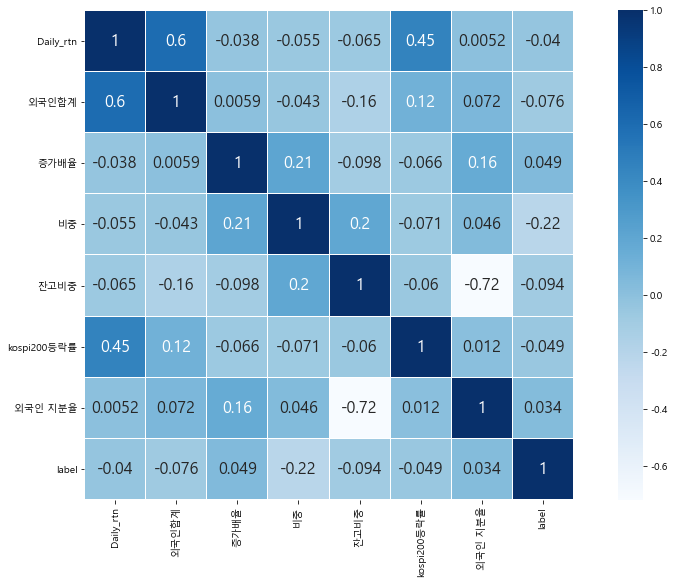

In [21]:
df_merge.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_merge.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 16})

* 다중공선성 발생 가능성이 높은 feature 삭제

In [22]:
df_merge.drop(['Daily_rtn'], axis=1, inplace=True)
df_merge

,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율,label
날짜,,,,,,,
2019-03-06,2656256000,0.59000,8.29000,0.76000,-0.21000,45.53125,0.12339
2019-03-07,-11038402000,0.42000,4.06000,0.73000,-0.35000,45.56250,0.09841
2019-03-08,-10034182000,1.04000,6.91000,0.70000,-1.45000,45.50000,0.07463
2019-03-11,-7524774000,0.41000,5.00000,0.67000,0.08000,45.46875,0.06593
2019-03-12,-7987946000,0.61000,9.69000,0.66000,0.97000,45.28125,0.02990
...,...,...,...,...,...,...,...
2022-03-08,-5661773000,0.23000,4.10000,1.30000,-1.03000,41.75000,-0.09432
2022-03-10,-16757808000,1.86000,17.88000,1.37000,2.47000,41.71875,-0.11859
2022-03-11,-25765070000,0.89000,9.64000,1.42000,-0.75000,41.62500,-0.12184


<AxesSubplot:>

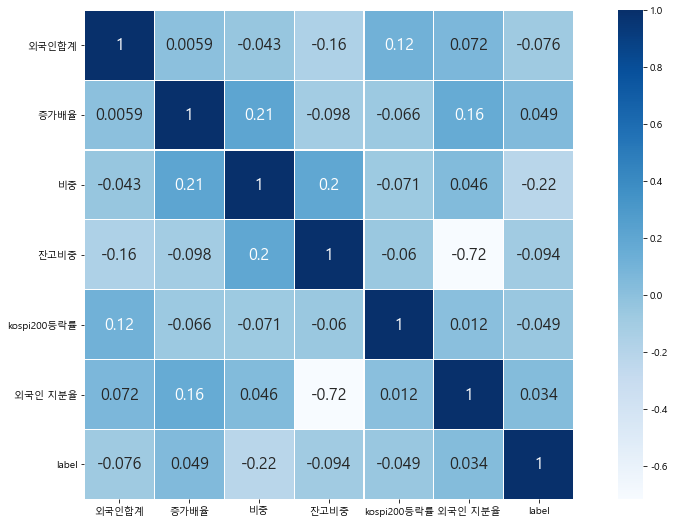

In [23]:
df_merge.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_merge.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 16})

* label을 5일동안 수익률이 -5%일 때 1, 나머지를 0으로 설정

In [24]:
for i in range(len(df_merge)):

    if df_merge['label'][i] <= -0.05:
        df_merge['label'][i] = 1
    else :
        df_merge['label'][i] = 0

* label을 features가 있는 데이터프레임과 분리

In [25]:
df_data = df_merge.drop(['label'],axis=1)
df_target = df_merge['label']

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [27]:
df_data

,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율
날짜,,,,,,
2019-03-06,2656256000,0.59000,8.29000,0.76000,-0.21000,45.53125
2019-03-07,-11038402000,0.42000,4.06000,0.73000,-0.35000,45.56250
2019-03-08,-10034182000,1.04000,6.91000,0.70000,-1.45000,45.50000
2019-03-11,-7524774000,0.41000,5.00000,0.67000,0.08000,45.46875
2019-03-12,-7987946000,0.61000,9.69000,0.66000,0.97000,45.28125
...,...,...,...,...,...,...
2022-03-08,-5661773000,0.23000,4.10000,1.30000,-1.03000,41.75000
2022-03-10,-16757808000,1.86000,17.88000,1.37000,2.47000,41.71875
2022-03-11,-25765070000,0.89000,9.64000,1.42000,-0.75000,41.62500


* '외국인합계'와 '잔고수량'의 값이 커서 MinMaxScaler를 통해 전처리

In [28]:
from sklearn.preprocessing import MinMaxScaler
min = MinMaxScaler()
min_scaled = min.fit_transform(df_data)
minmax_fit = pd.DataFrame(min_scaled, columns=['외국인합계', '증가배율', '비중', '잔고비중', 'kospi200등락률', '외국인 지분율'])
minmax_fit

,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율
0,0.45912,0.01779,0.23829,0.39370,0.44352,0.80347
1,0.40180,0.01266,0.11670,0.37008,0.43520,0.80925
2,0.40601,0.03135,0.19862,0.34646,0.36980,0.79769
3,0.41651,0.01236,0.14372,0.32283,0.46076,0.79191
4,0.41457,0.01839,0.27853,0.31496,0.51367,0.75723
...,...,...,...,...,...,...
743,0.42431,0.00693,0.11785,0.81890,0.39477,0.10405
744,0.37787,0.05607,0.51394,0.87402,0.60285,0.09827
745,0.34017,0.02683,0.27709,0.91339,0.41141,0.08092
746,0.31392,0.04432,0.22823,1.00000,0.44411,0.04624


In [30]:
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


In [31]:
X_train, X_test, y_train, y_test = train_test_split(minmax_fit, df_target, test_size=0.2, random_state=7)

In [32]:
num_folds = 10
scoring = 'roc_auc'

In [33]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


In [34]:
results = []
names = []
num_folds = 10
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=num_folds, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.686703 (0.091396)
LDA: 0.685123 (0.095089)
KNN: 0.828582 (0.044625)
CART: 0.742511 (0.057035)
NB: 0.759315 (0.122562)
SVM: 0.813355 (0.054150)
NN: 0.773606 (0.075358)
AB: 0.822325 (0.067291)
GBM: 0.864370 (0.043539)
RF: 0.890179 (0.036540)
ET: 0.902435 (0.047224)


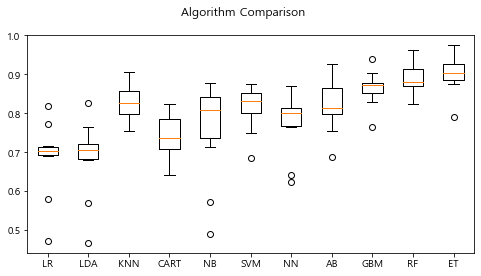

In [35]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()


In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

In [37]:
n_estimators = [20,50,100]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train, y_train)


In [38]:
estimator = grid_result.best_estimator_
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)
pred = estimator.predict(X_test)
print(accuracy_score(y_test, pred))

최고예측 정확도: 0.8664693661833252 최적 하이퍼 파라미터 : {'max_depth': 5, 'n_estimators': 100}
0.78


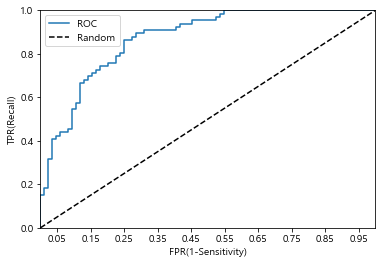

In [39]:
pred_proba_class1 = estimator.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0],5)
plt.plot(fprs, tprs, label='ROC')
plt.plot([0,1],[0,1], 'k--', label='Random')

start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1),2))
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
plt.legend()
plt.show()

In [40]:
print(classification_report(y_test, pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.76      0.88      0.82        84
     class 1       0.81      0.65      0.72        66

    accuracy                           0.78       150
   macro avg       0.79      0.77      0.77       150
weighted avg       0.78      0.78      0.78       150



In [41]:
# threshold 최대값의 인덱스, np.argmax()
# pred_proba_class1 = estimator.predict_proba(X_test)[:,1]
# fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
optimal_idx = np.argmax(tprs - fprs)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 38 , threshold: 0.3900260657964325


In [42]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
pred_proba = estimator.predict_proba(X_test)
custom_threshold = 0.3900260657964325

# Positive 컬럼에 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

# 테스트 레이블 데이터셋: y_test

# 오차행렬
print('오차행렬:', '\n',  confusion_matrix(y_test, custom_predict))
print(classification_report(y_test, custom_predict))

오차행렬: 
 [[63 21]
 [10 56]]
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80        84
         1.0       0.73      0.85      0.78        66

    accuracy                           0.79       150
   macro avg       0.80      0.80      0.79       150
weighted avg       0.80      0.79      0.79       150

